此处为附带的训练脚本，其中包含了使用附件各库的逻辑及完整训练与测试逻辑，最后一部分的单元格中包含了可用于提交的`agent`代码

需要注意的是： 由于我同时在本机与`vlab`平台上进行多种参数的测试，本脚本中并没有包含报告中的所有测试结果，但保证基本逻辑的正确性

并且需要特别注意的是：`agent_minmax`系列已经大幅度修改，仅保留了最终修缮结果（即`agent_minmax_4`），因此其它`minmax`版本后方带有的数字表示的是最终算法允许的深度情况，而非版本信息

---

In [3]:
import os
import shutil
import random
import numpy as np
from agent_minmax import agent_minmax
from stable_baselines3 import PPO, DQN
from ConnectXTrainer import ConnectXTrainer
from kaggle_environments import make, evaluate
from agent_minmax_2 import agent_minmax_2
from agent_minmax_3 import agent_minmax_3
from agent_minmax_4 import agent_minmax_4
from agent_random import agent_random

D:\python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def load_model(model_path):
    try:
        model = PPO.load(model_path)
    except:
        model = DQN.load(model_path)
    print(f"模型已从 {model_path} 加载")
    return model

# 跑 100 次
def test_win_rate(agent1, agent2=agent_minmax, num_episodes=100):
    rewards = evaluate(
        "connectx", [agent1, agent2], configuration={}, num_episodes=num_episodes
    )
    valid_rewards = [r for r in rewards if r[0] is not None and r[1] is not None]

    if not valid_rewards:
        print("No valid games were played.")
        return 0.0

    # 计算 agent1 的胜率
    win_rate = sum(1 for r in valid_rewards if r[0] > r[1]) / len(valid_rewards)
    return win_rate


def rename_models(prefix="offensive", models_path_raw=None):
    for file_path in models_path_raw:
        dir_name, base_name = os.path.split(file_path)
        split_index = base_name.find("_")
        if split_index != -1:
            new_name = f"{prefix}{base_name[split_index:]}"
        else:
            new_name = f"{prefix}_{base_name}"
        new_path = os.path.join(dir_name, new_name)
        shutil.move(file_path, new_path)
        print(f"文件已重命名: {file_path} -> {new_path}")

In [4]:
# 训练
tensorboard_log = "./connectx_tensorboard/"
if os.path.exists(tensorboard_log):
    shutil.rmtree(tensorboard_log)  # 删除旧日志目录
trainer = ConnectXTrainer(model_type="DQN", opponent=agent_minmax_2)
model, off_model_paths = trainer.train(
    total_timesteps=300_000, tensorboard_log=tensorboard_log
)
rename_models(prefix="offensive", models_path_raw=off_model_paths)

Using cpu device
Logging to ./connectx_tensorboard/PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.35     |
|    ep_rew_mean     | -8.4     |
| time/              |          |
|    fps             | 362      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 6.35        |
|    ep_rew_mean          | -7.6        |
| time/                   |             |
|    fps                  | 349         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.027736673 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.93       |
|    explained_

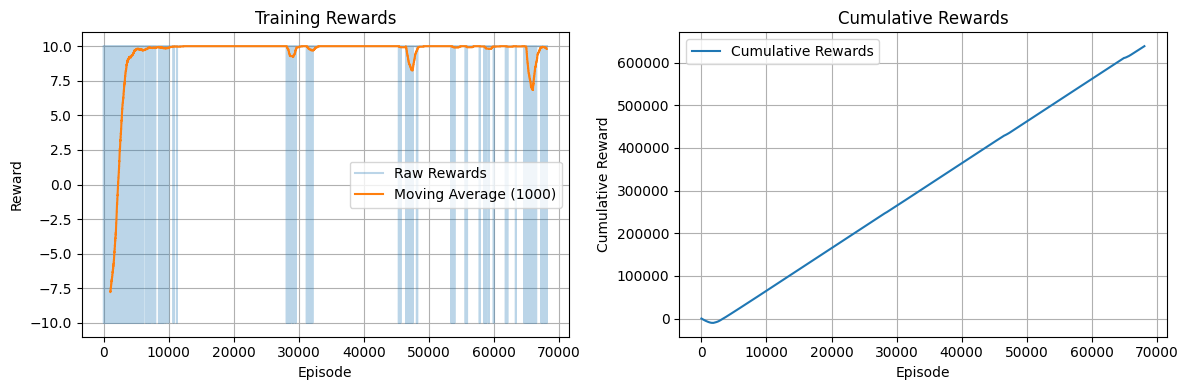

总回合数: 68087
平均奖励: 9.38
最高奖励: 10.00
最低奖励: -10.00
最后100回合平均奖励: 9.40


In [5]:
trainer.show(window_size=1000)

In [4]:
# 正反手测试
offensive_model_path = "./connectx_models/offensive_final.zip"  # 注意，此处并不固定，可能是best_model更好，也可能的final更好（例如验证策略采用随机指标时，final会更好）
global offensive_agent_model
offensive_agent_model = load_model(offensive_model_path)

def agent(observation, configuration):
    """Kaggle agent接口，负责动作决策"""
    # 构造观察状态
    board = observation.board
    current_player = observation.mark
    obs = np.array(board + [current_player], dtype=np.int32)

    # 获取模型预测
    action, _ = offensive_agent_model.predict(
        obs, deterministic=True
    )  # deterministic表示模型取概率最高的动作（否则会随机）
    # 确保动作有效
    possible_actions = [c for c in range(configuration.columns) if board[c] == 0]

    if action in possible_actions:
        return int(action)
    else:
        # 如果预测动作无效，随机选择一个有效动作
        return random.choice(possible_actions) if possible_actions else 0

模型已从 ./connectx_models/offensive_final.zip 加载


In [4]:
# 正反手测试
offensive_model_path_ = "./offensive_final.zip"  # 注意，此处并不固定，可能是best_model更好，也可能的final更好（例如验证策略采用随机指标时，final会更好）
global offensive_agent_model_
offensive_agent_model_ = load_model(offensive_model_path_)


def agent_(observation, configuration):
    """Kaggle agent接口，负责动作决策"""
    # 构造观察状态
    board = observation.board
    current_player = observation.mark
    obs = np.array(board + [current_player], dtype=np.int32)

    # 获取模型预测
    action, _ = offensive_agent_model_.predict(
        obs, deterministic=True
    )  # deterministic表示模型取概率最高的动作（否则会随机）
    # 确保动作有效
    possible_actions = [c for c in range(configuration.columns) if board[c] == 0]

    if action in possible_actions:
        return int(action)
    else:
        # 如果预测动作无效，随机选择一个有效动作
        return random.choice(possible_actions) if possible_actions else 0

模型已从 ./offensive_final.zip 加载


In [7]:
print(f"Agent vs random 胜率（正手）：{test_win_rate(agent, 'random', num_episodes=100)}")
print(f"Agent vs random 胜率（反手）：{1- test_win_rate('random', agent, num_episodes=100)}")
print(f"Agent vs minmax 胜率（正手）：{test_win_rate(agent, agent_minmax_2, num_episodes=100)}")
print(f"Agent vs minmax 胜率（反手）：{1-test_win_rate(agent_minmax_2, agent, num_episodes=100)}")

Agent vs random 胜率（正手）：0.81
Agent vs random 胜率（反手）：0.76
Agent vs minmax 胜率（正手）：1.0
Agent vs minmax 胜率（反手）：0.0


In [5]:
print(f"Agent vs random 胜率（正手）：{test_win_rate(agent_, 'random', num_episodes=100)}")
print(f"Agent vs random 胜率（反手）：{1- test_win_rate('random', agent_, num_episodes=100)}")
print(f"Agent vs minmax 胜率（正手）：{test_win_rate(agent_, agent_minmax, num_episodes=100)}")
print(f"Agent vs minmax 胜率（反手）：{1-test_win_rate(agent_minmax, agent_, num_episodes=100)}")

Agent vs random 胜率（正手）：0.77
Agent vs random 胜率（反手）：0.85
Agent vs minmax 胜率（正手）：1.0
Agent vs minmax 胜率（反手）：0.0


In [10]:
print(f"Agent vs Agent 胜率（正手）：{test_win_rate(agent, agent_, num_episodes=100)}")
print(f"Agent vs Agent 胜率（反手）：{1-test_win_rate(agent_, agent, num_episodes=100)}")

Agent vs minmax 胜率（正手）：0.66
Agent vs minmax 胜率（反手）：0.41000000000000003


In [6]:
# 提取模型的权重信息
state_dict = offensive_agent_model_.policy.to("cpu").state_dict()
import torch

# 保存权重到文件
torch.save(state_dict, "model_weights.pth")

print("模型权重已保存到文件 'model_weights.pth'")

# 打印提取的权重信息
print("\n提取的模型权重信息：")
for name, param in state_dict.items():
    print(f"{name}: {param.size()}")

模型权重已保存到文件 'model_weights.pth'

提取的模型权重信息：
mlp_extractor.policy_net.0.weight: torch.Size([64, 43])
mlp_extractor.policy_net.0.bias: torch.Size([64])
mlp_extractor.policy_net.2.weight: torch.Size([64, 64])
mlp_extractor.policy_net.2.bias: torch.Size([64])
mlp_extractor.value_net.0.weight: torch.Size([64, 43])
mlp_extractor.value_net.0.bias: torch.Size([64])
mlp_extractor.value_net.2.weight: torch.Size([64, 64])
mlp_extractor.value_net.2.bias: torch.Size([64])
action_net.weight: torch.Size([7, 64])
action_net.bias: torch.Size([7])
value_net.weight: torch.Size([1, 64])
value_net.bias: torch.Size([1])


In [3]:
import numpy as np
import torch
from torch import nn as nn

class AgentPPO(nn.Module):
    def __init__(self):
        super(AgentPPO, self).__init__()
        # 特征提取器
        self.features_extractor = nn.Flatten(start_dim=1, end_dim=-1)
        # 策略网络特征提取器
        self.pi_features_extractor = nn.Flatten(start_dim=1, end_dim=-1)
        # 值网络特征提取器
        self.vf_features_extractor = nn.Flatten(start_dim=1, end_dim=-1)
        # MLP提取器
        self.mlp_extractor = nn.ModuleDict(
            {
                "policy_net": nn.Sequential(
                    nn.Linear(43, 64), nn.Tanh(), nn.Linear(64, 64), nn.Tanh()
                ),
                "value_net": nn.Sequential(
                    nn.Linear(43, 64), nn.Tanh(), nn.Linear(64, 64), nn.Tanh()
                ),
            }
        )
        self.action_net = nn.Linear(64, 7)
        self.value_net = nn.Linear(64, 1)

    def forward(self, x):
        # 特征提取
        x = self.features_extractor(x)
        # 策略网络
        pi_features = self.pi_features_extractor(x)
        policy_output = self.mlp_extractor["policy_net"](pi_features)
        action_logits = self.action_net(policy_output)
        # 值网络
        vf_features = self.vf_features_extractor(x)
        value_output = self.mlp_extractor["value_net"](vf_features)
        value = self.value_net(value_output)
        return action_logits, value


# 初始化模型
model = AgentPPO()
model = model.float()
model.load_state_dict(
    torch.load(
        "model_weights.pth", map_location="cuda" if torch.cuda.is_available() else "cpu"
    )
)
model = model.to("cpu")
model = model.eval()


def preprocess_observation(board, mark, configuration):
    """
    本次编写的棋盘接受43维输入  6*7+1
    """
    # 将board转换为6x7的矩阵（ConnectX标准尺寸）
    rows, cols = configuration.rows, configuration.columns
    board_2d = np.array(board).reshape(rows, cols)

    # 创建特征向量（43维）
    features = []

    # 1. 棋盘状态特征 (展平，42维: 6*7)
    board_flat = board_2d.flatten()
    features.extend(board_flat)

    # 2. 当前玩家标识 (1维)
    current_player = mark
    features.append(current_player)

    return np.array(features, dtype=np.float32)


def agent(observation, configuration):
    # 获取棋盘状态并预处理为43维
    processed_obs = preprocess_observation(
        observation["board"], observation.mark, configuration
    )
    obs_tensor = torch.tensor(processed_obs, dtype=torch.float32).reshape(1, -1)

    with torch.no_grad():
        action_logits, _ = model(obs_tensor)

        # 获取有效动作
        board_2d = np.array(observation["board"]).reshape(
            configuration.rows, configuration.columns
        )
        valid_actions = []
        for col in range(configuration.columns):
            if board_2d[0, col] == 0:
                valid_actions.append(col)
        # 如果没有有效动作，返回随机动作（理论上不应该发生）
        if not valid_actions:
            return np.random.choice(configuration.columns)
        # 只考虑有效动作
        action_mask = torch.full((configuration.columns,), float("-inf"))
        for valid_action in valid_actions:
            action_mask[valid_action] = 0
        masked_logits = action_logits.squeeze(0) + action_mask

        # 选择最佳动作
        action = torch.argmax(masked_logits).item()

    return int(action)

In [9]:
import time
print(test_win_rate(agent_minmax_3, "random", num_episodes=100))
print(1 - test_win_rate("random", agent_minmax_3, num_episodes=100))
print(test_win_rate("negamax", "random", num_episodes=100))
print(1 - test_win_rate("random", "negamax", num_episodes=100))
st1 = time.time()
print(test_win_rate(agent_minmax_3, "negamax", num_episodes=100))
print(1 - test_win_rate("negamax", agent_minmax_3, num_episodes=100))
print("耗时：", time.time() - st1)

1.0
1.0
0.99
0.99
0.8
0.88
耗时： 413.38471269607544


In [10]:
print(test_win_rate(agent_random, "random", num_episodes=100))
print(1 - test_win_rate("random", agent_random, num_episodes=100))

0.96
0.97


In [11]:
print(test_win_rate(agent_random, "negamax", num_episodes=100))
print(1 - test_win_rate("negamax", agent_random, num_episodes=100))

0.23
0.48


In [5]:
import time

st1 = time.time()
print(test_win_rate(agent_minmax_3, agent_minmax_3, num_episodes=10))
print("耗时：", time.time() - st1)
st1 = time.time()
print(1 - test_win_rate(agent_minmax_4, agent_minmax_4, num_episodes=10))
print("耗时：", time.time() - st1)

0.6
耗时： 34.6394202709198
0.8
耗时： 37.06715798377991


In [6]:
# 测试 agent
env = make("connectx", debug=True)
env.run([agent_random, agent_random])
env.render(mode="ipython", width=600, height=500, header=False)